In [1]:
import ehrapy as ep
import seaborn as sns
import numpy as np
import pandas as pd
import re
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from dowhy import CausalModel
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import graphviz
import networkx as nx 

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)


In [2]:
from drugbankpy import DrugBankConnector
dbc = DrugBankConnector("../drugbank_all_full_database.xml.zip") 

In [3]:
dbc.find_drug("hydrocortisonesodiumsuccinate", exact=False, fuzzy_threshold=70, return_best=True)

First time using connector, loading drugs...


,drugbank_id,primary_name,alias_name,type,groups,atc_codes,categories,inchikey,inchi,description,clean_alias_name,fuzzy_score,edit_distance
223728,DB14545,Hydrocortisone succinate,Hydrocortisone succinate,small molecule,approved,,11-Hydroxycorticosteroids|17-Hydroxycorticoste...,VWQWXZAWFPZJDA-CGVGKPPMSA-N,InChI=1S/C25H34O8/c1-23-9-7-15(26)11-14(23)3-4...,,hydrocortisonesuccinate,88,6


In [4]:
drugs = dbc.load_drugs(return_df=True)
drugs.head(3)

,drugbank_id,primary_name,alias_name,type,groups,atc_codes,categories,inchikey,inchi,description
0,DB00001,Lepirudin,Lepirudin,biotech,approved|withdrawn,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",None,None,Lepirudin is a recombinant hirudin formed by 6...
1,DB00001,Lepirudin,Refludan,biotech,approved|withdrawn,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",None,None,Lepirudin is a recombinant hirudin formed by 6...
2,DB00002,Cetuximab,Cetuximab,biotech,approved,L01FE01,"Amino Acids, Peptides, and Proteins|Antibodies...",None,None,Cetuximab is a recombinant chimeric human/mous...


In [5]:
def remove_concatenation_symbols(names):
    pattern = r"[\s_\-]"  # Pattern to match whitespaces, underscores, and hyphens
    return "".join(re.split(pattern, names.lower()))


def remove_descriptors(names):
    descriptors = ["ointment", 
                   "Injection", 
                   "for_Injection", 
                   "Oral_Solution", 
                   "inhalation", 
                   "Capsules",
                   "Soft_Capsules",
                   "Drops",
                   "for_Intra_Venous",
                   "Eye_Drops",
                   "Inhalation_Solution",
                   "Tablets",
                   "Injectable_Emulsion",
                   "Cream",
                   "powder"]
    
    # regex to match any of the descriptors
    pattern = r"\b(" + "|".join(re.escape(descriptor) for descriptor in descriptors) + r")\b"
    
    # remove descriptors 
    cleaned_names = re.sub(pattern, "", names, flags=re.IGNORECASE)
    
    return cleaned_names.strip()

drugs["cleaned_names"] = drugs["alias_name"].apply(remove_descriptors)

drugs.cleaned_names

0            Lepirudin
1             Refludan
2            Cetuximab
3              Erbitux
4                     
              ...     
228456         AUM-601
228457         FN-1501
228458    Tinengotinib
228459       Lipotecan
228460    Xenon Xe-129
Name: cleaned_names, Length: 228461, dtype: object

In [6]:
adata = ep.io.read_h5ad("../adata_pneumonia.h5ad")
adata_df = adata.to_df()
adata_df = pd.DataFrame(adata.layers["original_imputed"], columns=adata_df.columns)
obs = pd.DataFrame(adata.obs).reset_index()

adata_df = pd.concat([adata_df, obs], axis=1)
adata_df.columns = adata_df.columns.str.replace(" ", "_")

adata_cols = pd.DataFrame(adata_df.columns, columns=["original"])
adata_cols = adata_cols[~adata_cols["original"].str.contains("ehrapycat|leiden|received|_max|_min")]
adata_cols["unmodified"] = adata_cols["original"]
adata_cols["original"] = adata_cols["original"].str.replace("_avg", "")
adata_cols["cleaned_names"] = adata_cols["original"].apply(remove_concatenation_symbols)
adata_cols["cleaned_names"] = adata_cols["original"].apply(remove_descriptors)
adata_cols

,original,unmodified,cleaned_names
35,LOS,LOS,LOS
38,Eosinophils,Eosinophils_avg,Eosinophils
41,ALB/GLB,ALB/GLB_avg,ALB/GLB
44,adenosine_deaminase,adenosine_deaminase_avg,adenosine_deaminase
47,Albumin,Albumin_avg,Albumin
...,...,...,...
471,ethnicity,ethnicity,ethnicity
472,Death,Death,Death
477,sputum_positive_bacteria,sputum_positive_bacteria,sputum_positive_bacteria
478,sputum_positive_fungi,sputum_positive_fungi,sputum_positive_fungi


In [7]:
def find_best_match(drug: pd.Series):
    
    try:
        match = dbc.find_drug(drug["cleaned_names"], exact=False, fuzzy_threshold=70, return_best=True)
    except:
        match = None
    
    if match is not None:
        drugbank_id = match["drugbank_id"].values[0]
        alias_name = match["alias_name"].values[0]
        fuzzy_score = match["fuzzy_score"].values[0]
        edit_distance = match["edit_distance"].values[0]
    else:
        drugbank_id = None
        alias_name = None
        fuzzy_score = None
        edit_distance = None
    
    result = pd.DataFrame({
        "original": [drug["original"]],
        "cleaned_names": [drug["cleaned_names"]],
        "alias_name": [alias_name],
        "drugbank_id": [drugbank_id],
        "fuzzy_score": [fuzzy_score],
        "edit_distance": [edit_distance],
    })
        
    return result
    

def worker(element):
    # Worker function for parallel execution
    match = find_best_match(element)
    return match

executor = ThreadPoolExecutor()

best_matches = []
with tqdm(total=len(adata_cols)) as pbar:
    futures = [executor.submit(worker, row) for _, row in adata_cols.iterrows()]
    for future in tqdm(futures):
        match = future.result()
        best_matches.append(match)
        pbar.update(1)

100%|██████████| 297/297 [11:15<00:00,  2.27s/it]


In [17]:
col_drug_matches = pd.concat(best_matches)
col_drug_matches.head(3)

,original,cleaned_names,alias_name,drugbank_id,fuzzy_score,edit_distance
0,LOS,LOS,Losec,DB00338,75,2
0,Eosinophils,Eosinophils,Fosinopril,DB00492,31,3
0,ALB/GLB,ALB/GLB,None,None,None,None


## Manually verify the drugs
Compare alias_names to drug names and see if they match.

In [9]:
col_drug_matches.to_csv("./col_drug_matches.csv", index=False, sep=";")

In [20]:
col_drug_matches_verified = pd.read_csv("./col_drug_matches_verified.csv", sep=";")
col_drug_matches_verified.head(3)

,original,cleaned_names,alias_name,drugbank_id,fuzzy_score,edit_distance,match
0,Albumin,Albumin,Albumin (Human),DB00062,100.0,7.0,1
1,Urea,Urea,(4-(trifluoromethoxy)phenyl)urea,DB15610,100.0,28.0,0
2,"Calcium,_Total","Calcium,_Total",Calcium,DB01373,100.0,7.0,1


## Count categories of all matches

In [21]:
tmp_drugs = drugs.set_index("alias_name", inplace=False)
tmp_cdmv = col_drug_matches_verified.set_index("alias_name", inplace=False)

tmp = tmp_drugs.join(tmp_cdmv, lsuffix="_x", rsuffix="_y")
tmp = tmp.query("match == 1")
tmp.head(3)

,drugbank_id_x,primary_name,type,groups,atc_codes,categories,inchikey,inchi,description,cleaned_names_x,clean_alias_name,fuzzy_score_x,original,cleaned_names_y,drugbank_id_y,fuzzy_score_y,edit_distance,match
alias_name,,,,,,,,,,,,,,,,,,
0.9% Sodium Chloride Injection,DB09153,Sodium chloride,small molecule,approved|vet_approved,B05XA03|B05CB01|A12CA01,Alimentary Tract and Metabolism|Blood and Bloo...,FAPWRFPIFSIZLT-UHFFFAOYSA-M,InChI=1S/ClH.Na/h1H;/q;+1/p-1,"Sodium chloride, also known as salt, common sa...",0.9% Sodium Chloride,0.9%sodiumchlorideinjection,33,0.9%_Sodium_Chloride_Injection,0.9%_Sodium_Chloride_Injection,DB09153,95.0,3.0,1.0
Albumin (Human),DB00062,Albumin human,biotech,approved,B05AA01,"Albumins|Amino Acids, Peptides, and Proteins|B...",None,None,Human serum albumin is the primary protein pre...,Albumin (Human),albumin(human),30,Albumin,Albumin,DB00062,100.0,7.0,1.0
Alprostadil Injection USP,DB00770,Alprostadil,small molecule,approved|investigational,C01EA01|G04BE01,Autacoids|Biological Factors|Cardiac Therapy|C...,GMVPRGQOIOIIMI-DWKJAMRDSA-N,InChI=1S/C20H34O5/c1-2-3-6-9-15(21)12-13-17-16...,Alprostadil is produced endogenously and cause...,Alprostadil USP,alprostadilinjectionusp,43,Alprostadil_Injection,Alprostadil_Injection,DB00770,91.0,4.0,1.0


In [22]:
cat_membership = tmp["categories"].str.get_dummies(sep="|")
col_sums = cat_membership.sum(axis=0)

term_counts = pd.DataFrame({"term": cat_membership.columns, "count": col_sums})
term_counts = term_counts.sort_values(by="count", ascending=False)
term_counts.reset_index(drop=True, inplace=True)
term_counts
term_counts.to_csv("./term_counts.csv", index=False, sep=";")

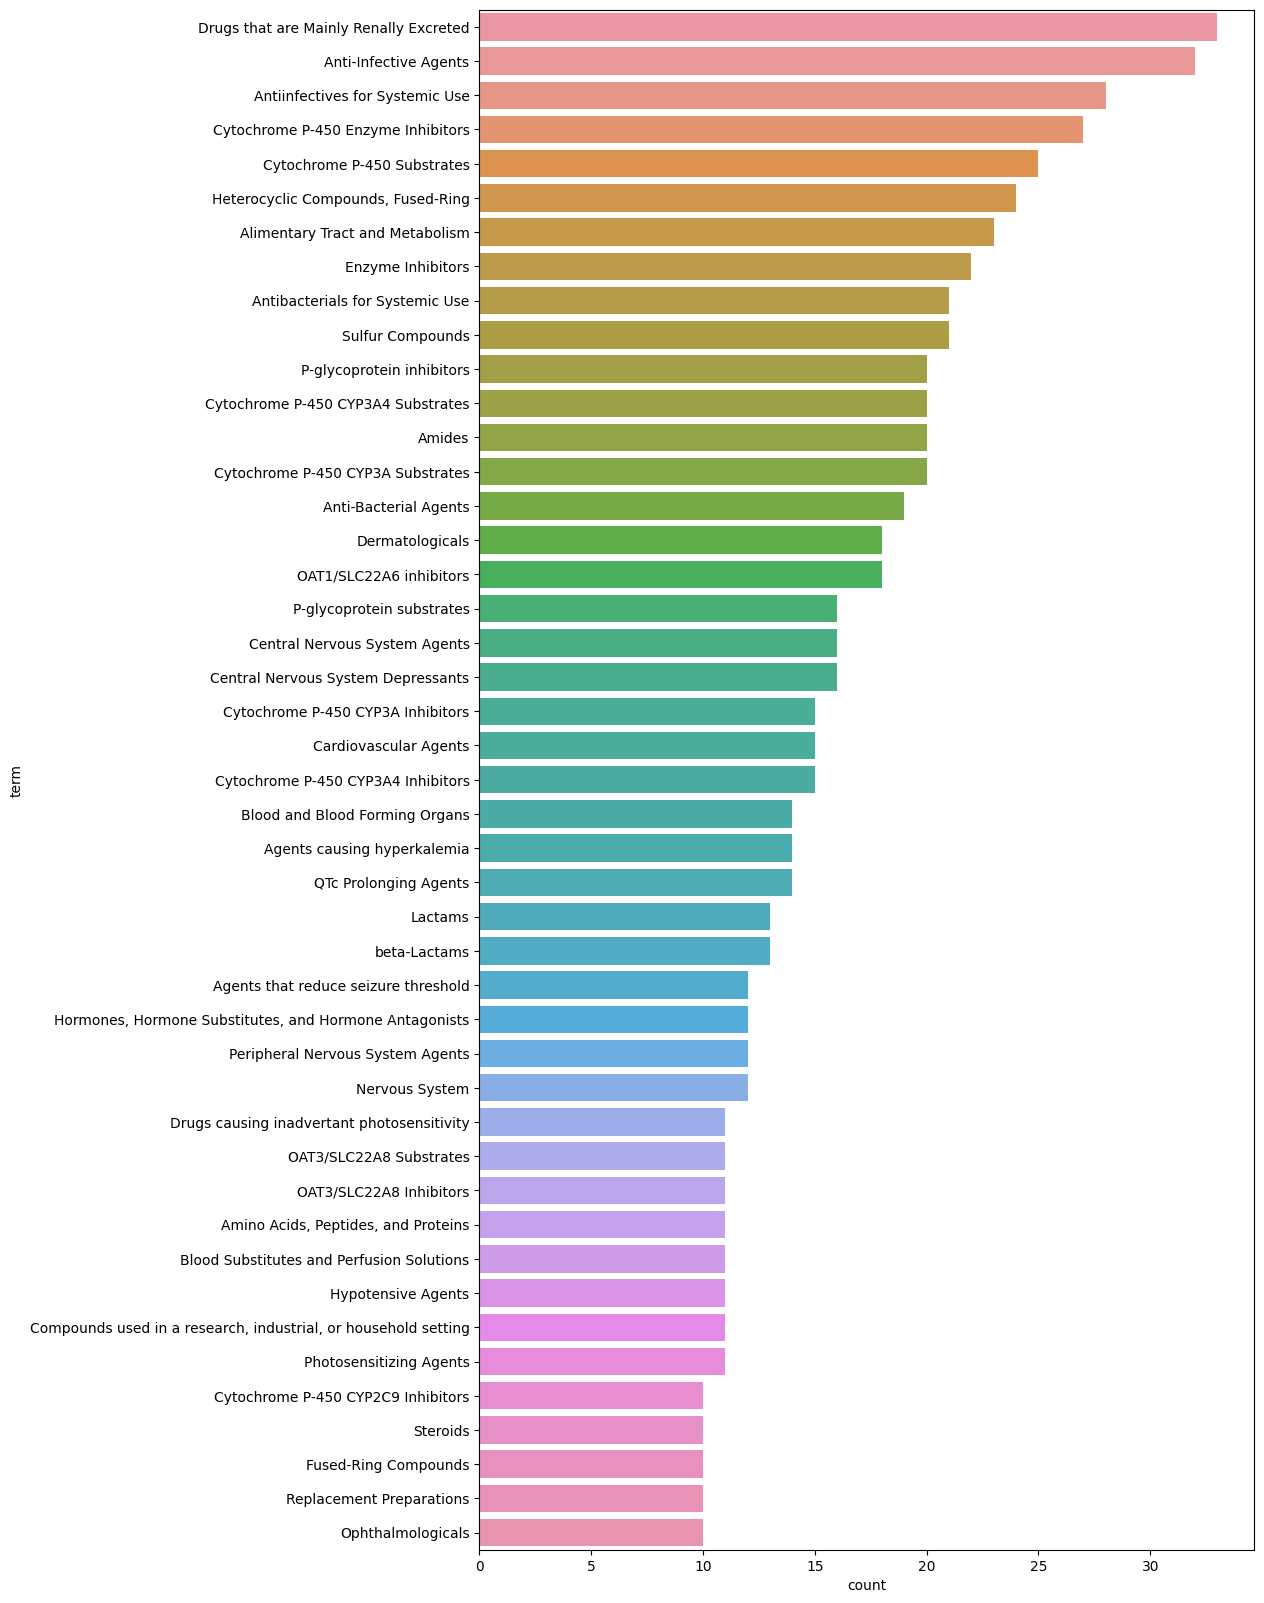

In [23]:
plt.figure(figsize=(10, 20))
sns.barplot(x='count', y='term', data=term_counts.query("count >= 10"), orient='h')
plt.show()

In [25]:
results = []
featurised = pd.DataFrame()

for term in term_counts.query("count >= 1").term:

    drugnames = cat_membership.query(f"`{term}` == 1").index
    filtered_df = col_drug_matches[col_drug_matches["alias_name"].isin(drugnames)]
    true_colnames = filtered_df.merge(adata_cols, left_on="original", right_on="original", how="left")["unmodified"]
    subset = adata_df[true_colnames]
    pos = (subset > 0).any(axis=1).astype(int).to_frame()
    featurised[term] = pos
    pos_counted = pos.sum()[0]
    neg_counted = len(subset) - pos_counted

    results.append({
        'term': term,
        'pos': pos_counted,
        'neg': neg_counted
    })

results_df = pd.DataFrame(results)
results_df["ratio"] = results_df["pos"] / results_df["neg"]
results_df = results_df.sort_values(by="term", ascending=False)
results_df

,term,pos,neg,ratio
808,i.v. Solutions,33,244,0.135246
27,beta-Lactams,110,167,0.658683
130,beta-Lactamase Inhibitors,37,240,0.154167
437,"alpha-Galactosidase, antagonists & inhibitors",0,277,0.000000
436,Xanthine derivatives,0,277,0.000000
...,...,...,...,...
131,Acetamides,46,231,0.199134
639,ACE Inhibitors and Diuretics,16,261,0.061303
640,17-Hydroxycorticosteroids,0,277,0.000000
169,14-alpha Demethylase Inhibitors,74,203,0.364532


In [26]:
featurised.columns = featurised.columns.str.replace(" ", "_")
featurised.columns = ["drugcat_" + col for col in featurised.columns]
featurised

,drugcat_Drugs_that_are_Mainly_Renally_Excreted,drugcat_Anti-Infective_Agents,drugcat_Antiinfectives_for_Systemic_Use,drugcat_Cytochrome_P-450_Enzyme_Inhibitors,drugcat_Cytochrome_P-450_Substrates,"drugcat_Heterocyclic_Compounds,_Fused-Ring",drugcat_Alimentary_Tract_and_Metabolism,drugcat_Enzyme_Inhibitors,drugcat_Antibacterials_for_Systemic_Use,drugcat_Sulfur_Compounds,...,"drugcat_Fatty_Acids,_Unsaturated","drugcat_Fatty_Acids,_Monounsaturated",drugcat_Factor_VIII_Activator,drugcat_Explosive_Agents,drugcat_Expectorants,drugcat_Excitatory_Amino_Acid_Antagonists,drugcat_Excitatory_Amino_Acid_Agents,drugcat_Ethylene_Glycols,drugcat_Ethanolamines,drugcat_i.v._Solutions
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,1
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
273,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,1
274,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
275,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Append to cohort data

In [65]:
adata = ep.io.read_h5ad("../adata_pneumonia.h5ad")
adata_df = adata.to_df()
adata_df = pd.DataFrame(adata.layers["original_imputed"], columns=adata_df.columns)

obs = pd.DataFrame(adata.obs).reset_index()

adata_df = pd.concat([adata_df, obs, featurised], axis=1)
adata_df.columns = adata_df.columns.str.replace(' ', '_')
adata_df.columns = adata_df.columns.str.replace('(', '')
adata_df.columns = adata_df.columns.str.replace(')', '')
adata_df.columns = adata_df.columns.str.replace('-', '_')

for col in adata_df.columns:
    try:
        adata_df[col] = adata_df[col].astype(float)
    except ValueError:
        del adata_df[col]
    
    
adata_df.to_csv("./adata_pneumonia_drugcats_added.csv", index=False, sep="\t")
adata_df

,ehrapycat_received_rest_0.0,ehrapycat_received_rest_1.0,ehrapycat_sputum_positive_bacteria_0.0,ehrapycat_sputum_positive_bacteria_1.0,ehrapycat_sputum_positive_fungi_0.0,ehrapycat_sputum_positive_fungi_1.0,ehrapycat_ethnicity_Han_ethnic,ehrapycat_ethnicity_Miao_ethnic,ehrapycat_ethnicity_Others,ehrapycat_ethnicity_Tujia_ethnic,...,"drugcat_Fatty_Acids,_Unsaturated","drugcat_Fatty_Acids,_Monounsaturated",drugcat_Factor_VIII_Activator,drugcat_Explosive_Agents,drugcat_Expectorants,drugcat_Excitatory_Amino_Acid_Antagonists,drugcat_Excitatory_Amino_Acid_Agents,drugcat_Ethylene_Glycols,drugcat_Ethanolamines,drugcat_i.v._Solutions
0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
274,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
adata_df.filter(like='euco', axis=1).columns

Index([], dtype='object')